Inspired by https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

In [1]:
#For reproducable results on CPU:
#from numpy.random import seed
#seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
#!pip uninstall tensorflow
#!pip3 install --upgrade tensorflow-gpu==1.4

import os
import math
import numpy as np
from numpy import newaxis
import pandas as pd

from keras.layers import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.models import Sequential
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

if not os.path.exists(os.path.join(os.getcwd(), 'saved_models')):
    os.makedirs(os.path.join(os.getcwd(), 'saved_models'))

Using TensorFlow backend.


In [2]:
# Importing the dataset
!curl https://raw.githubusercontent.com/muke888/UdemyDeepLearning/master/3.%20Recurrent%20Neural%20Networks/Datasets/TSLA.csv -o Tesla.csv
  
data = pd.read_csv('Tesla.csv')
data.info()
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  119k  100  119k    0     0   607k      0 --:--:-- --:--:-- --:--:--  607k
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151 entries, 0 to 2150
Data columns (total 6 columns):
Date      2151 non-null object
Open      2151 non-null float64
High      2151 non-null float64
Low       2151 non-null float64
Close     2151 non-null float64
Volume    2151 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 100.9+ KB


,Date,Open,High,Low,Close,Volume
0,29/06/2010,19.000000,25.00,17.540001,23.889999,18766300
1,30/06/2010,25.790001,30.42,23.299999,23.830000,17187100
2,1/07/2010,25.000000,25.92,20.270000,21.959999,8218800
3,2/07/2010,23.000000,23.10,18.709999,19.200001,5139800
4,6/07/2010,20.000000,20.00,15.830000,16.110001,6866900


In [0]:
#sequence_length=60
#input_dims=2 #2 cols used Close & Volume
configs={
	"data": {
		"filename": "Tesla.csv",
		"columns": ["Close","Volume"],
		"sequence_length": 60,
		"train_test_split": 0.85,
		"normalise": True
	},
	"training": {
		"epochs": 300,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"save_dir":os.path.join(os.getcwd(), 'saved_models'),
		"layers": [
			{
				"type": "CuDNNLSTM",
				"neurons": 100,
				#"input_shape": (59, 2),
        "input_timesteps": 59, #sequence_length - 1
				"input_dim": 2,
				"return_seq": True
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "CuDNNLSTM",
				"neurons": 100,
				"return_seq": True
			},
        {
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "CuDNNLSTM",
				"neurons": 100,
				"return_seq": False
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}

In [0]:
class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def generate_train_batch2(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        while True:
          i = 0
          while i < (self.len_train - seq_len):
              x_batch = []
              y_batch = []
              for b in range(batch_size):
                  if i >= (self.len_train - seq_len):
                      # stop-condition for a smaller final batch if data doesn't divide evenly
                      yield np.array(x_batch), np.array(y_batch)
                      i = 0
                  x, y = self._next_window(i, seq_len, normalise)
                  x_batch.append(x)
                  y_batch.append(y)
                  i += 1
              yield np.array(x_batch), np.array(y_batch)        
            
            
            
    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [0]:
import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))

In [0]:
class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'CuDNNLSTM':
				self.model.add(CuDNNLSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)

		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir, validation_data, validation_steps):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1,
      validation_data=validation_data,
      validation_steps=validation_steps 
    )
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted

In [0]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


def main():
    #configs = settings

    data = DataLoader(
        configs['data']['filename'],
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch2(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    # predictions = model.predict_point_by_point(x_test)

    plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    # plot_results(predictions, y_test)

In [0]:
#main()

In [9]:
data = DataLoader(
        configs['data']['filename'],
        configs['data']['train_test_split'],
        configs['data']['columns'])

model = Model()

model.build_model(configs)

x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise'])
# out-of memory generative training

steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
validation_steps = math.ceil((data.len_test - configs['data']['sequence_length']) / configs['training']['batch_size'])

x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise'])

model.train_generator(
        data_gen=data.generate_train_batch2(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir'],
        validation_data = (x_test, y_test),
        validation_steps = validation_steps)



[Model] Model Compiled
Time taken: 0:00:06.767688
[Model] Training Started
[Model] 300 epochs, 32 batch size, 56 batches per epoch
Epoch 1/300
56/56 [==============================] - 6s 101ms/step - loss: 0.0554 - val_loss: 0.0141
Epoch 2/300
56/56 [==============================] - 3s 61ms/step - loss: 0.0721 - val_loss: 0.0142
Epoch 3/300
56/56 [==============================] - 3s 58ms/step - loss: 0.0676 - val_loss: 0.0101
Epoch 4/300
56/56 [==============================] - 3s 58ms/step - loss: 0.0483 - val_loss: 0.0083
Epoch 5/300
56/56 [==============================] - 4s 63ms/step - loss: 0.0504 - val_loss: 0.0083
Epoch 6/300
56/56 [==============================] - 3s 59ms/step - loss: 0.0478 - val_loss: 0.0076
Epoch 7/300
56/56 [==============================] - 3s 58ms/step - loss: 0.0459 - val_loss: 0.0072
Epoch 8/300
56/56 [==============================] - 3s 58ms/step - loss: 0.0299 - val_loss: 0.0070
Epoch 9/300
56/56 [==============================] - 4s 65ms/step - 

In [0]:
#predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

#plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
# plot_results(predictions, y_test)

[Model] Predicting Point-by-Point...


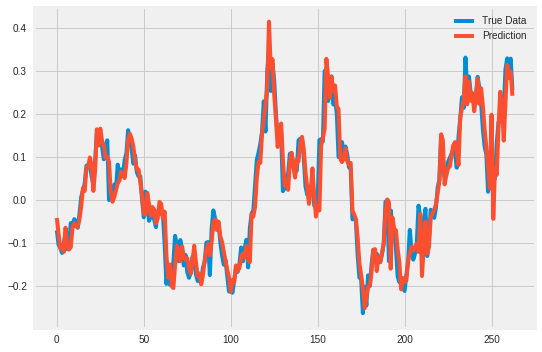

In [11]:
predictions = model.predict_point_by_point(x_test)
plot_results(predictions, y_test)

[Model] Predicting Sequences Full...


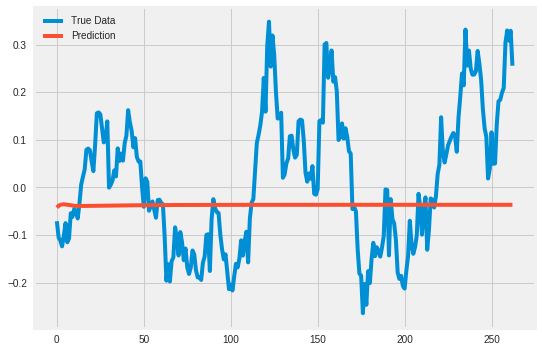

In [12]:
predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
plot_results(predictions, y_test)

[Model] Predicting Sequences Multiple...


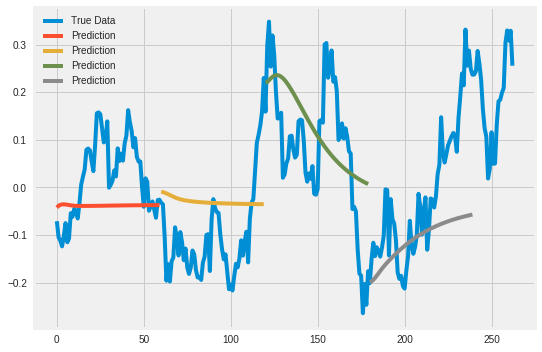

In [13]:
predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], 60)
plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])